In [1]:
import os
import pandas as pd
import glob
import numpy as np
import nltk
import matplotlib.pyplot as plt
import string

In [2]:
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, PlaintextCorpusReader,stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from scipy.ndimage import zoom
from scipy import stats

lemmatizer = WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
    
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
             #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


def blob_sentiment(txt):
    sent = TextBlob(txt).sentiment.polarity
    return sent

Extend the existing stopword list of nltk with flukes and misspelling in pdf's

In [3]:
stop_words = set(stopwords.words('english'))
newStopWords = ['authenticity', 'certified', 'text', 'version', 'transcribed', 'directly',\
                'audio', '--', 'aa', '?', ';', 'page', '12/31/21', ')', ',', "n't", '(', ']',\
                '[', '!', 'updated', '12/11/21', 'update', "``", "''", 'rr', "'ve", "'s",\
                'mmeerriiccaann', 'hheettoorriiccccoomm', 'hheettoorriicc', '..', ',', ':', \
                'ccoomm', 'transcription', 'americanrhetoric.com','and', 'the', 'to', 'of', 'in',\
                'that', 'is', 'a', 'have', 'with', 'be', 'this', 'as', 'by', 'those', '--', 'are', \
                'but', 'your',  'for', 'they', 'here', 'their', 'but', 'were', 'at', 'aa', 'rr', 'www',\
                'mmeerriiccaann', 'hheettoorriicc..ccoomm', 'transcription','1','2','3', 'transcription',\
                'americanrhetoric.com', 'updated', '12/31/21', 'page','ccoomm','hheettoorriicc','would','11',\
                'michael','e','eidenmuller','also','americanrhetoric','com','w','oodrow','ilson','mauricio',\
                'garcia','21','10','12','may','let','new','say','said','make','go','mr','come','could',\
                'get','many','authenticity', 'certified', 'text', 'version', 'transcribed', 'directly', 'audio', '--', \
                'aa', '?', ';', 'page', '12/31/21', ')', ',', "n't", '(', ']', '[', '!', 'updated', '12/11/21', 'update', \
                "``", "''", 'rr', "'ve", "'s", 'mmeerriiccaann', 'hheettoorriiccccoomm', 'hheettoorriicc', '..', ',', ':',\
                'ccoomm', 'transcription', 'americanrhetoric.com', "trump","clinton","mccain","brownback", "bachmann", "bauer", \
                "bradley", "bush", "cain", "carson", "christie", "cruz", "dodd", "edwards", "forbes", "gbush", "gimore", "gingrich",\
                "giuliani", "gore", "graham", "hatch", "huckabee", "hunter", "huntsman", "jindal", "johnson", "kaine", \
                "kasich", "obama", "pataki", "paul", "pawlenty", "perry", "richardson", "romney", \
                "rubio", "sanders", "santorum", "tancredo", "thompson", "walker", "webb"]
stop_words.update(newStopWords)

In [4]:
database = [ ]
corpus = PlaintextCorpusReader("/root/.jupyter/FINAL/DATA", ".*\.txt")
files=corpus.fileids()
for f in files:
    number_of_sentences = len(corpus.sents(f))
    number_of_words = len(
        [word for sentence in corpus.sents(f) for word in sentence])
    number_of_fids = len(corpus.fileids())
    path = "/root/.jupyter/FINAL/DATA/"
    newstr = "".join((path, f))
    with open(newstr, encoding= 'Latin') as speech_file:
        number = str(''.join(filter(str.isdigit, f)))
        f = f.replace(".txt", "")
        debater = ''.join(filter(lambda x: not x.isdigit(), f))
        contents = speech_file.read()
        contents = contents.lower()
        contents_no_punct = contents.translate(str.maketrans('', '', string.punctuation))
        
        words = word_tokenize(contents_no_punct)
        words_punct = word_tokenize(contents)
        sentences = sent_tokenize(contents)
        
        # With full stops (for sentences):
        contents_without_stopwords_punct = []
        for w in words_punct:
            if w not in stop_words:
                contents_without_stopwords_punct.append(w)
        as_one_string_withpunct = ' '.join(contents_without_stopwords_punct)
 
        without_stop_lem_sentences = lemmatize_sentence(as_one_string_withpunct)
        lines = without_stop_lem_sentences.split(".")
        tempdf = pd.DataFrame(lines)
        tempdf.columns = ['text']
        tempdf['sentiment_blob'] = ''
    
        tempdf['sentiment_blob'] = tempdf['text'].apply(lambda x : blob_sentiment(x))
        sentiments = tempdf.sentiment_blob.to_list()

        speeches = {
            'filename' : f,
            'content' : speech_file.read(),
            'debater' : debater,
            'debate_number' : number,
            'number_of_sentences' : number_of_sentences,
            'number_of_words' : number_of_words,
            'average_sentence_length': number_of_words/number_of_sentences,
            'sentiment': sentiments,
            'lemmatized': without_stop_lem_sentences}  
        

    database.append(speeches)
debates_df = pd.DataFrame(database)
#df.info()



In [5]:
database2 = [ ]

for i in range(0,len(os.listdir("/root/.jupyter/FINAL/text_files"))):
    speech_name = os.listdir("/root/.jupyter/FINAL/text_files")[i]
    with open("/root/.jupyter/FINAL/text_files/"+speech_name,encoding="utf8", errors='ignore') as f:
        contents = f.read()
        contents = contents.lower()
        contents_no_punct = contents.translate(str.maketrans('', '', string.punctuation))
    
    words = word_tokenize(contents_no_punct)
    words_punct = word_tokenize(contents)
    sentences = sent_tokenize(contents)


    # With full stops (for sentences):
    contents_without_stopwords_punct = []
    for w in words_punct:
        if w not in stop_words:
            contents_without_stopwords_punct.append(w)
    as_one_string_withpunct = ' '.join(contents_without_stopwords_punct)
    
    without_stop_lem_sentences = lemmatize_sentence(as_one_string_withpunct)
    lines = without_stop_lem_sentences.split(".")
    tempdf = pd.DataFrame(lines)
    tempdf.columns = ['text']
    tempdf['sentiment_blob'] = ''
    
    tempdf['sentiment_blob'] = tempdf['text'].apply(lambda x : blob_sentiment(x))
    sentiments = tempdf.sentiment_blob.to_list()
    number_of_words = len(words)
    average_sentence_length = len(sentences)/len(words)
    number_of_sentences = len(sentences)
    #master.loc[len(master.index)] = [speech_name, speech_name, 1, number_of_sentences, number_of_words,\
    #                                 average_sentence_length, sentiments]
    
    speeches = {
            'filename' : speech_name,
            'content' : contents,
            'debater' : speech_name,
            'debate_number' : 1,
            'number_of_sentences' : number_of_sentences,
            'number_of_words' : number_of_words,
            'average_sentence_length': average_sentence_length,
            'sentiment': sentiments,
            'lemmatized': without_stop_lem_sentences
        
        }  
        

    database2.append(speeches)
    
speeches_df = pd.DataFrame(database2)




speech_titles = []
authors = []
first_names = []
surname = []
for i in range(0,len(speeches_df.filename)):
    author = speeches_df.filename[i]
    author = author.replace('FDR Pearl Harbor.txt','FDR - Pearl Harbor.txt')
    author = author.split("-")[0]
    author = author.replace('FDR','Franklin D. Roosevelt')
    author = author.strip()
    authors.append(author)
for i in range(0,len(speeches_df.filename)):
    speech_title = speeches_df.filename[i]
    speech_title = speech_title.replace('FDR Pearl Harbor.txt','FDR - Pearl Harbor.txt')
    speech_title = speech_title.split("-")[1]
    speech_title = speech_title.strip()
    speech_title = speech_title.split(".")[0]
    speech_titles.append(speech_title)
for i in authors:
    sep = i.split(' ')[-1]
    surname.append(sep)
for i in authors:
    sep = i.split(' ')[:-1]
    sep = ' '.join(sep)
    first_names.append(sep)
speeches_df['debater'] = surname
speeches_df['speaker_firstnames'] = first_names
speeches_df['speech_title'] = speech_titles
speeches_df['author'] = authors




In [6]:
print("shortest speech is", min(speeches_df.sentiment.map(len)), "sentences long",  
      "\nlongest speech is", max(speeches_df.sentiment.map(len)), "sentences long")

print("shortest debate is", min(debates_df.sentiment.map(len)), "sentences long",  
      "\nlongest debate is", max(debates_df.sentiment.map(len)), "sentences long")

shortest speech is 26 sentences long 
longest speech is 721 sentences long
shortest debate is 21 sentences long 
longest debate is 764 sentences long


In [7]:
# Spline interpolation to stretch all vectors of sentiment scores into a common length (800)

stretch_length = 800

zoomed_debates = []
for sp in debates_df['sentiment']:
    arr = np.array(sp)
    zoom_rate = stretch_length / arr.shape[0]
    zoomed = zoom(arr, zoom_rate)
    zoomed_debates.append(zoomed)
zoomed_speeches = []
for sp in speeches_df['sentiment']:
    arr = np.array(sp)
    zoom_rate = stretch_length / arr.shape[0]
    zoomed = zoom(arr, zoom_rate)
    zoomed_speeches.append(zoomed)
speeches_df['zoomed_textblob'] = zoomed_speeches
debates_df['zoomed_textblob'] = zoomed_debates

In [8]:
print("number of speech timepoints after stretching: ", max(speeches_df.zoomed_textblob.map(len)))
print("number of speeches (rows): ", len(speeches_df.zoomed_textblob))
print("number of debate timepoints after stretching: ", max(debates_df.zoomed_textblob.map(len)))
print("number of debates (rows): ", len(debates_df.zoomed_textblob))

number of speech timepoints after stretching:  800
number of speeches (rows):  80
number of debate timepoints after stretching:  800
number of debates (rows):  374


In [9]:
# standardise stretched scores into new column
stand_cumsum_speeches = []
for sp in speeches_df['zoomed_textblob']:
    standardised_line = stats.zscore(sp.cumsum())
    stand_cumsum_speeches.append(standardised_line)
speeches_df['stretched_zscores'] = stand_cumsum_speeches
stand_cumsum_debates = []
for sp in debates_df['zoomed_textblob']:
    standardised_line = stats.zscore(sp.cumsum())
    stand_cumsum_debates.append(standardised_line)
debates_df['stretched_zscores'] = stand_cumsum_debates

In [10]:
# this coverts the list of stretched, standardised sentiment SPEECH vectors into a dataframe
lst = list(range(1,stretch_length+1))
lst = [str(x) for x in lst]
colnames = ["t" + x for x in lst]
as_dataframe = pd.DataFrame(speeches_df.stretched_zscores)
clustering_speeches_df = pd.DataFrame(speeches_df['stretched_zscores'].to_list(), columns=colnames)

# this coverts the list of stretched, standardised sentiment DEBATE vectors into a dataframe
lst = list(range(1,stretch_length+1))
lst = [str(x) for x in lst]
colnames = ["t" + x for x in lst]
as_dataframe = pd.DataFrame(debates_df.stretched_zscores)
clustering_debates_df = pd.DataFrame(debates_df['stretched_zscores'].to_list(), columns=colnames)

In [11]:
#Remove ".txt" from speech filenames
fff = []
for i in speeches_df['filename']:
    row = i[:-4]
    fff.append(row)
speeches_df['filename'] = fff
    



In [12]:
#Combine debates and speeches dataframes:

clustering_speeches_debates_df = pd.concat([clustering_debates_df, clustering_speeches_df])
to_append = speeches_df.drop(columns =['speaker_firstnames', 'speech_title', 'author'])
debates_df['type'] = "debate"
to_append['type'] = "great_speech"
speeches_debates_df = pd.concat([debates_df, to_append])
speeches_debates_df = speeches_debates_df.reset_index()




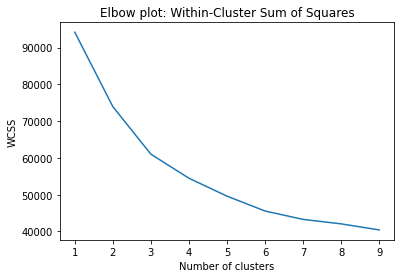

In [13]:
# Elbow plot for selecting number of kmeans clusters (3 or 4?)
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,10):
    kmeans = KMeans(i)
    kmeans.fit(clustering_speeches_debates_df)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.title('Elbow plot: Within-Cluster Sum of Squares')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() 

In [14]:
# using four clusters for kmeans, on debates and speeches together:
kmeans = KMeans(n_clusters=4, random_state=95461)
kmeans.fit(clustering_speeches_debates_df)
speeches_debates_df['kmeans4_clusters_ALL'] = kmeans.fit_predict(clustering_speeches_debates_df)+1


In [15]:

cdeb_spch_1 = speeches_debates_df[speeches_debates_df['kmeans4_clusters_ALL']==1].reset_index()
cdeb_spch_2 = speeches_debates_df[speeches_debates_df['kmeans4_clusters_ALL']==2].reset_index()
cdeb_spch_3 = speeches_debates_df[speeches_debates_df['kmeans4_clusters_ALL']==3].reset_index()
cdeb_spch_4 = speeches_debates_df[speeches_debates_df['kmeans4_clusters_ALL']==4].reset_index()


av_cdeb_spch_1 = np.mean(cdeb_spch_1['stretched_zscores'])
av_cdeb_spch_2 = np.mean(cdeb_spch_2['stretched_zscores'])
av_cdeb_spch_3 = np.mean(cdeb_spch_3['stretched_zscores'])
av_cdeb_spch_4 = np.mean(cdeb_spch_4['stretched_zscores'])


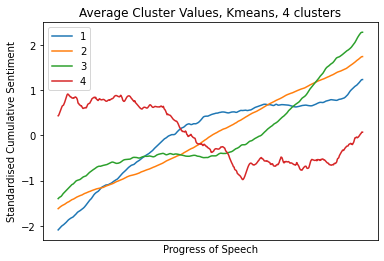

In [16]:
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
plt.plot(av_cdeb_spch_1,label="1")
plt.plot(av_cdeb_spch_2,label="2")
plt.plot(av_cdeb_spch_3,label="3")
plt.plot(av_cdeb_spch_4,label="4")
plt.title("Average Cluster Values, Kmeans, 4 clusters")
plt.legend()
plt.xlabel("Progress of Speech")
plt.ylabel("Standardised Cumulative Sentiment")
plt.show() 


In [17]:
dist_from_k4cluster = []
for i in range(0,len(speeches_debates_df)):
    difference = speeches_debates_df['stretched_zscores'][i]-eval("av_cdeb_spch_" + str(speeches_debates_df['kmeans4_clusters_ALL'][i]))
    sum_sq_diff = sum(difference**2)
    dist_from_k4cluster.append(sum_sq_diff)
standardised_dist_from_k4cluster = (dist_from_k4cluster- np.mean(dist_from_k4cluster))/np.std(dist_from_k4cluster)
speeches_debates_df['standardised_dist_from_k4cluster']=standardised_dist_from_k4cluster    

In [18]:
# Create new column which gives the average cluster values for the Kmeans assigned cluster, for each row.

cluster_mean = []
for i in range(0,len(speeches_debates_df)):
    if speeches_debates_df['kmeans4_clusters_ALL'][i]==1:
        clust_av= av_cdeb_spch_1
    else:
        if speeches_debates_df['kmeans4_clusters_ALL'][i]==2:
            clust_av= av_cdeb_spch_2
        else: 
            if speeches_debates_df['kmeans4_clusters_ALL'][i]==3:
                clust_av= av_cdeb_spch_3
            else: 
                if speeches_debates_df['kmeans4_clusters_ALL'][i]==4:
                    clust_av=av_cdeb_spch_4
                else:
                    "error"
    cluster_mean.append(clust_av)
speeches_debates_df["cluster_average"] = cluster_mean

In [19]:
df1 = speeches_debates_df
%store df1
pd.set_option('display.max_rows', 500)
display(df1)

Stored 'df1' (DataFrame)


,index,filename,content,debater,debate_number,number_of_sentences,number_of_words,average_sentence_length,sentiment,lemmatized,zoomed_textblob,stretched_zscores,type,kmeans4_clusters_ALL,standardised_dist_from_k4cluster,cluster_average
0,0,Arraras22,,Arraras,22,32,684,21.375000,"[0.0, 0.23214285714285715, 0.0, 0.0, 0.0500000...",arrarãs dr. concern recommendation report can...,"[-1.0429013302451983e-17, 0.002166091701644538...","[-2.4795306805411514, -2.479133898023905, -2.4...",debate,1,0.573399,"[-2.091295968105255, -2.082433448779045, -2.07..."
1,1,Bachmann138,,Bachmann,138,118,2416,20.474576,"[0.28750000000000003, 0.0, 0.0, 0.0, 0.1, 0.0,...",well clear last five year four election first ...,"[0.28750000000000003, 0.268863180727894, 0.221...","[-1.4155369377790383, -1.383027204481087, -1.3...",debate,2,0.613472,"[-1.6220424549057153, -1.6141844053217562, -1...."
2,2,Bachmann145,,Bachmann,145,154,2919,18.954545,"[0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.4, 0.15, 0.0...",well one former competitor herman always remin...,"[3.6510280451932656e-17, -0.005829897047215938...","[-1.359557981023046, -1.3600315792019335, -1.3...",debate,2,-0.549418,"[-1.6220424549057153, -1.6141844053217562, -1...."
3,3,Bachmann151,,Bachmann,151,123,2162,17.577236,"[0.7, 0.0, 0.8, 0.0, 0.0, 0.9, 0.8, 0.5, 0.0, ...",good see wolf . applause name michele . 'm pro...,"[0.7000000000000001, 0.6424533793899072, 0.500...","[-2.910394694284999, -2.8159376219521137, -2.7...",debate,3,0.335001,"[-1.4004794769451518, -1.390677234215914, -1.3..."
4,4,Bachmann159,,Bachmann,159,89,1565,17.584270,"[-0.5, -0.025000000000000022, -0.3125, 0.1, 1....","absolutely unfortunate request make 40,000 tro...","[-0.5000000000000001, -0.4852085174025036, -0....","[-1.5882582965230718, -1.6222857119807614, -1....",debate,3,-0.321115,"[-1.4004794769451518, -1.390677234215914, -1.3..."
5,5,Bachmann167,,Bachmann,167,82,1529,18.646341,"[0.0, 0.05333333333333334, 0.05333333333333334...",well think one thing know tax lead job leave c...,"[1.7147917220431203e-17, 0.0007564799632859471...","[-1.9442435408616072, -1.9441774633580844, -1....",debate,1,-0.175523,"[-2.091295968105255, -2.082433448779045, -2.07..."
6,6,Bachmann175,,Bachmann,175,115,2130,18.521739,"[0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, -0.10...",hi name michele . thrill able tonight la vega ...,"[-2.044080479086168e-17, 0.0359047860113004, 0...","[-3.2571434806533572, -3.250006928283031, -3.2...",debate,1,2.128802,"[-2.091295968105255, -2.082433448779045, -2.07..."
7,7,Bachmann182,,Bachmann,182,113,2196,19.433628,"[0.09714285714285714, 0.0, 0.0, 0.0, 0.0, -0.5...",think look problem economic meltdown trace rig...,"[0.09714285714285717, 0.09125716549271623, 0.0...","[-0.9652783743742857, -0.9490958252250795, -0....",debate,2,0.137182,"[-1.6220424549057153, -1.6141844053217562, -1...."
8,8,Bachmann190,,Bachmann,190,79,1432,18.126582,"[0.1, 0.0, 0.0, 0.2, 0.07291666666666666, 0.0,...",debate talk young man wish answer question wan...,"[0.10000000000000002, 0.09828663721081711, 0.0...","[-0.9873936758279621, -0.9795499432636015, -0....",debate,3,0.013188,"[-1.4004794769451518, -1.390677234215914, -1.3..."
9,9,Bachmann199,,Bachmann,199,99,1985,20.050505,"[0.0, 0.7, 0.0, 0.0, 0.03333333333333333, 0.0,...",name michele . know much good country . 'm chi...,"[-2.864623541820113e-17, 0.036021062491983946,...","[-3.62616325865954, -3.613459511756225, -3.567...",debate,1,2.118164,"[-2.091295968105255, -2.082433448779045, -2.07..."


File name:  Paul60
Assigned cluster: 1
Standardised distance from cluster mean: -0.21945589629565745


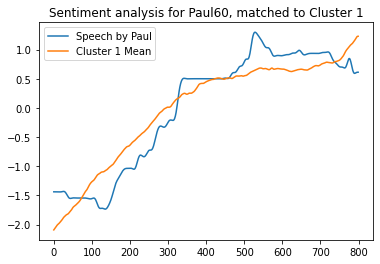

In [23]:
# Choose row number from speeches_debates_df to print the sentiment analaysis of that speech or debate, 
# alongside the average cluster value to which it is assigned 
rownum=258


clus_num = speeches_debates_df['kmeans4_clusters_ALL'][rownum]
print("File name: ",speeches_debates_df['filename'][rownum])
print("Assigned cluster:",speeches_debates_df['kmeans4_clusters_ALL'][rownum])
print("Standardised distance from cluster mean:",speeches_debates_df['standardised_dist_from_k4cluster'][rownum])
plt.plot(np.array(speeches_debates_df['stretched_zscores'][rownum]), label="Speech by " + speeches_debates_df['debater'][rownum])
plt.plot(np.array(speeches_debates_df['cluster_average'][rownum]), label="Cluster " +str(clus_num)+ " Mean")
plt.title("Sentiment analysis for " + speeches_debates_df['filename'][rownum] + ", matched to Cluster " + str(clus_num))
plt.legend()
plt.show()